### In this notebook, I clean records of wildfire data to be used as positive instances in machine learning.

In [1]:
# Standard library imports
import os
import warnings
warnings.filterwarnings('ignore')

# Third-party imports
import pandas as pd
import matplotlib.pyplot as plt

# Configuration
# Note: Update this path to your local data file location
# For Google Colab, use: "/content/drive/MyDrive/ALDA Project/National_USFS_Fire_Occurrence_Point_(Feature_Layer).csv"
DATA_PATH = "../data/National_USFS_Fire_Occurrence_Point_(Feature_Layer).csv"
OUTPUT_PATH = "../data/clean_dates_and_locs.csv"

# Geographic bounds for contiguous United States
# Source: https://en.wikipedia.org/wiki/List_of_extreme_points_of_the_United_States
LATITUDE_MIN = 24.52
LATITUDE_MAX = 49.38407
LONGITUDE_MIN = -124.73004
LONGITUDE_MAX = -66.94975

# Date range for filtering
DATE_START = "1950-01-01"
DATE_END = "2024-12-31"

In [2]:
# Load wildfire occurrence data
# Using low_memory=False to avoid dtype warnings for mixed-type columns
fire_df = pd.read_csv(DATA_PATH, low_memory=False)
print(f"Loaded dataset shape: {fire_df.shape}")

Loaded dataset shape: (582291, 35)


## Checking out the DF
- Used [this website](https://catalog.data.gov/dataset/national-usfs-fire-occurrence-point-feature-layer-d3233) to source data for fire ignitions
- Comes from the US Forest Service

In [3]:
# Display dataset overview
print(f"Dataset shape: {fire_df.shape}")
print(f"\nColumn names ({len(fire_df.columns)}):")
print(fire_df.columns.tolist())
print(f"\nFirst few rows:")
print(fire_df.head())

Dataset shape: (582291, 35)

Column names (35):
['X', 'Y', 'OBJECTID', 'GLOBALID', 'FIREOCCURID', 'CN', 'REVDATE', 'FIRENAME', 'COMPLEXNAME', 'FIREYEAR', 'UNIQFIREID', 'SOFIRENUM', 'LOCALFIRENUM', 'SECURITYID', 'DISCOVERYDATETIME', 'SIZECLASS', 'TOTALACRES', 'STATCAUSE', 'COMMENTS', 'DATASOURCE', 'FIREOUTDATETIME', 'OWNERAGENCY', 'UNITIDOWNER', 'PROTECTIONAGENCY', 'UNITIDPROTECT', 'LATDD83', 'LONGDD83', 'FIRETYPECATEGORY', 'POINTTYPE', 'PERIMEXISTS', 'FIRERPTQC', 'DBSOURCEID', 'DBSOURCEDATE', 'ACCURACY', 'SHAPE']

First few rows:
            X          Y   OBJECTID                                GLOBALID  \
0 -106.406890  36.288324  313655329  {02E94D62-D284-4760-819B-5DA7939C6A93}   
1 -107.243590  36.974714  313655330  {B180F8C6-F6DA-4F55-A2E3-F62E711C0633}   
2 -107.286090  36.586384  313655331  {BCD2E22D-471F-4A30-B2FF-9E33B68D59C6}   
3 -106.444690  36.543884  313655332  {68DB867D-BA27-4584-B5A8-8BBE7A46273B}   
4 -106.059347  36.281551  313655333  {B9AC5BE5-2198-4322-9D24-C6F3BFD

In [4]:
print(fire_df['DISCOVERYDATETIME'])

0         2014/07/03 00:00:00+00
1         2014/06/06 00:00:00+00
2         2014/07/28 00:00:00+00
3         2014/08/19 00:00:00+00
4         2014/08/26 00:00:00+00
                   ...          
582286    2005/09/11 00:00:00+00
582287    2010/04/08 00:00:00+00
582288    2009/09/29 00:00:00+00
582289    1996/07/06 00:00:00+00
582290    2021/07/14 00:15:02+00
Name: DISCOVERYDATETIME, Length: 582291, dtype: object


In [5]:
print(fire_df["TOTALACRES"])

0              0.10
1              0.50
2              0.10
3              0.25
4              0.10
            ...    
582286         0.50
582287         0.10
582288         0.10
582289        10.00
582290    963309.00
Name: TOTALACRES, Length: 582291, dtype: float64


In [6]:
# Check latitude and longitude ranges
print("Latitude range:")
print(f"  Min: {fire_df['LATDD83'].min()}")
print(f"  Max: {fire_df['LATDD83'].max()}")
print("\nLongitude range:")
print(f"  Min: {fire_df['LONGDD83'].min()}")
print(f"  Max: {fire_df['LONGDD83'].max()}")

Latitude range:
  Min: -117.23305
  Max: 438897.0

Longitude range:
  Min: -1038467.0
  Max: 1011212.77


- So the values for lattitude and longitude don't look great. Seems like there are probably some typos/misplaced decimals in this dataset.
- Longitude ranges from -180 to 180, lattitude ranges from -90 to 90.
- How many instances are there where the latitude or longitude is outside of the acceptable range for latitude?

In [7]:
# Check longitude values outside valid global range (-180 to 180)
LONGITUDE_GLOBAL_MIN = -180
LONGITUDE_GLOBAL_MAX = 180

count_outside_range = (
    (fire_df['LONGDD83'] < LONGITUDE_GLOBAL_MIN) | 
    (fire_df['LONGDD83'] > LONGITUDE_GLOBAL_MAX)
).sum()
print(f"Longitude values outside global range ({LONGITUDE_GLOBAL_MIN} to {LONGITUDE_GLOBAL_MAX}): {count_outside_range}")


Longitude values outside global range (-180 to 180): 8


In [8]:
# Check latitude values outside valid global range (-90 to 90)
LATITUDE_GLOBAL_MIN = -90
LATITUDE_GLOBAL_MAX = 90

count_outside_range = (
    (fire_df["LATDD83"] < LATITUDE_GLOBAL_MIN) | 
    (fire_df["LATDD83"] > LATITUDE_GLOBAL_MAX)
).sum()
print(f"Latitude values outside global range ({LATITUDE_GLOBAL_MIN} to {LATITUDE_GLOBAL_MAX}): {count_outside_range}")


Latitude values outside global range (-90 to 90): 210


- Going to narrow the scope a bit. How many of these values are outside the range of the United States?
- Source of extreme points of US from here: http://www.cohp.org/extremes/extreme_points.html

### Checking to see how many points have lattitude and longitude that either doesn't exist or is outside of the United States
- I'd like to use Geopy's API or Google clouds API to return the country for every lattitude and longitude, but I would exceed the rate limits quickly for both.
- I think I would have to pay for both of these thigns
- Rather, I will just check and see if the latitude and longitude exist outside of the max and min of the united states. It is not perfect but it should help get rid of typos and stuff.
- Extreme points from here: https://en.wikipedia.org/wiki/List_of_extreme_points_of_the_United_States
- Also going to keep this to the contiguous United States here. Sorry Alaska and Hawaii!

In [9]:
# Check longitude values outside contiguous US range
count_outside_range = (
    (fire_df['LONGDD83'] < LONGITUDE_MIN) | 
    (fire_df['LONGDD83'] > LONGITUDE_MAX)
).sum()
print(f"Longitude values outside contiguous US range ({LONGITUDE_MIN} to {LONGITUDE_MAX}): {count_outside_range}")


Longitude values outside contiguous US range (-124.73004 to -66.94975): 8512


In [10]:
# Check latitude values outside contiguous US range
count_outside_range = (
    (fire_df["LATDD83"] < LATITUDE_MIN) | 
    (fire_df["LATDD83"] > LATITUDE_MAX)
).sum()
print(f"Latitude values outside contiguous US range ({LATITUDE_MIN} to {LATITUDE_MAX}): {count_outside_range}")

Latitude values outside contiguous US range (24.52 to 49.38407): 4849


I will plan to drop these values during data cleaning

### Exploring the dates in the dataframe, making sure they are ok

In [11]:
# Extract and check year range from discovery datetime
years = fire_df["DISCOVERYDATETIME"].str[:4].astype(float)
print(f"Year range in dataset:")
print(f"  Min year: {years.min()}")
print(f"  Max year: {years.max()}")
print(f"\nSample years:")
print(fire_df["DISCOVERYDATETIME"].str[:4].head(10))


Year range in dataset:
  Min year: 1001.0
  Max year: 2024.0

Sample years:
0    2014
1    2014
2    2014
3    2014
4    2014
5    2014
6    2015
7    2015
8    2015
9    2015
Name: DISCOVERYDATETIME, dtype: object


In [12]:
print(fire_df["DISCOVERYDATETIME"])

0         2014/07/03 00:00:00+00
1         2014/06/06 00:00:00+00
2         2014/07/28 00:00:00+00
3         2014/08/19 00:00:00+00
4         2014/08/26 00:00:00+00
                   ...          
582286    2005/09/11 00:00:00+00
582287    2010/04/08 00:00:00+00
582288    2009/09/29 00:00:00+00
582289    1996/07/06 00:00:00+00
582290    2021/07/14 00:15:02+00
Name: DISCOVERYDATETIME, Length: 582291, dtype: object


In [13]:
# Clean date column: convert to datetime and filter by date range
fire_df["DISCOVERYDATE"] = pd.to_datetime(
    fire_df["DISCOVERYDATETIME"], 
    errors='coerce'
).dt.date

# Drop rows with invalid dates (NaT or incorrect format)
cleaned_fire_df = fire_df.dropna(subset=["DISCOVERYDATE"])

# Filter dates between specified start and end dates
date_start = pd.to_datetime(DATE_START).date()
date_end = pd.to_datetime(DATE_END).date()

cleaned_fire_df = cleaned_fire_df[
    (cleaned_fire_df["DISCOVERYDATE"] >= date_start) &
    (cleaned_fire_df["DISCOVERYDATE"] <= date_end)
]

# Display results
print(f"Rows after date cleaning: {cleaned_fire_df.shape[0]}")
print(f"\nSample cleaned dates:")
print(cleaned_fire_df[["DISCOVERYDATE"]].head())


Rows after date cleaning: 528892

Sample cleaned dates:
  DISCOVERYDATE
0    2014-07-03
1    2014-06-06
2    2014-07-28
3    2014-08-19
4    2014-08-26


In [14]:
# Verify cleaned dataframe shape
print(f"Cleaned dataframe shape: {cleaned_fire_df.shape}")
print(f"Rows removed: {fire_df.shape[0] - cleaned_fire_df.shape[0]}")

Cleaned dataframe shape: (528892, 36)
Rows removed: 53399


## clean the latitude and longitude column

In [15]:
# Filter dataframe to keep only rows within valid latitude range for contiguous US
lat_clean_fire_df = cleaned_fire_df[
    (cleaned_fire_df["LATDD83"] >= LATITUDE_MIN) & 
    (cleaned_fire_df["LATDD83"] <= LATITUDE_MAX)
]

print(f"Rows after latitude filtering: {lat_clean_fire_df.shape[0]}")
print(f"Rows removed: {cleaned_fire_df.shape[0] - lat_clean_fire_df.shape[0]}")
print(f"\nSample latitudes:")
print(lat_clean_fire_df[["LATDD83"]].head())


Rows after latitude filtering: 523599
Rows removed: 5293

Sample latitudes:
    LATDD83
0  36.28832
1  36.97471
2  36.58638
3  36.54388
4  36.28155


In [16]:
# Filter dataframe to keep only rows within valid longitude range for contiguous US
latlong_clean_fire_df = lat_clean_fire_df[
    (lat_clean_fire_df['LONGDD83'] >= LONGITUDE_MIN) & 
    (lat_clean_fire_df['LONGDD83'] <= LONGITUDE_MAX)
]

print(f"Rows after longitude filtering: {latlong_clean_fire_df.shape[0]}")
print(f"Rows removed: {lat_clean_fire_df.shape[0] - latlong_clean_fire_df.shape[0]}")
print(f"\nSample longitudes:")
print(latlong_clean_fire_df[['LONGDD83']].head())


Rows after longitude filtering: 519891
Rows removed: 3708

Sample longitudes:
    LONGDD83
0 -106.40689
1 -107.24359
2 -107.28609
3 -106.44469
4 -106.05935


### Test to make sure it worked

In [17]:
# Verify longitude filtering: should be 0 values outside range
count_outside_range = (
    (latlong_clean_fire_df['LONGDD83'] < LONGITUDE_MIN) | 
    (latlong_clean_fire_df['LONGDD83'] > LONGITUDE_MAX)
).sum()
print(f"Longitude values outside valid range: {count_outside_range} (should be 0)")


Longitude values outside valid range: 0 (should be 0)


In [18]:
# Verify latitude filtering: should be 0 values outside range
count_outside_range = (
    (latlong_clean_fire_df["LATDD83"] < LATITUDE_MIN) | 
    (latlong_clean_fire_df["LATDD83"] > LATITUDE_MAX)
).sum()
print(f"Latitude values outside valid range: {count_outside_range} (should be 0)")

Latitude values outside valid range: 0 (should be 0)


In [19]:
# Final shape after geographic filtering
print(f"Final dataframe shape after geographic filtering: {latlong_clean_fire_df.shape}")

Final dataframe shape after geographic filtering: (519891, 36)


## Cleaning acres column

In [20]:
# Clean acres column: convert to numeric and filter valid values
acres_clean_df = latlong_clean_fire_df.copy()

# Convert to numeric (handles any non-numeric values)
acres_clean_df["TOTALACRES"] = pd.to_numeric(
    acres_clean_df["TOTALACRES"], 
    errors="coerce"
)

# Drop rows where TOTALACRES is NaN
acres_clean_df = acres_clean_df.dropna(subset=["TOTALACRES"])

# Remove non-positive values (acres must be > 0)
acres_clean_df = acres_clean_df[acres_clean_df["TOTALACRES"] > 0]

print(f"Rows after acres cleaning: {acres_clean_df.shape[0]}")
print(f"Rows removed: {latlong_clean_fire_df.shape[0] - acres_clean_df.shape[0]}")


Rows after acres cleaning: 516892
Rows removed: 2999


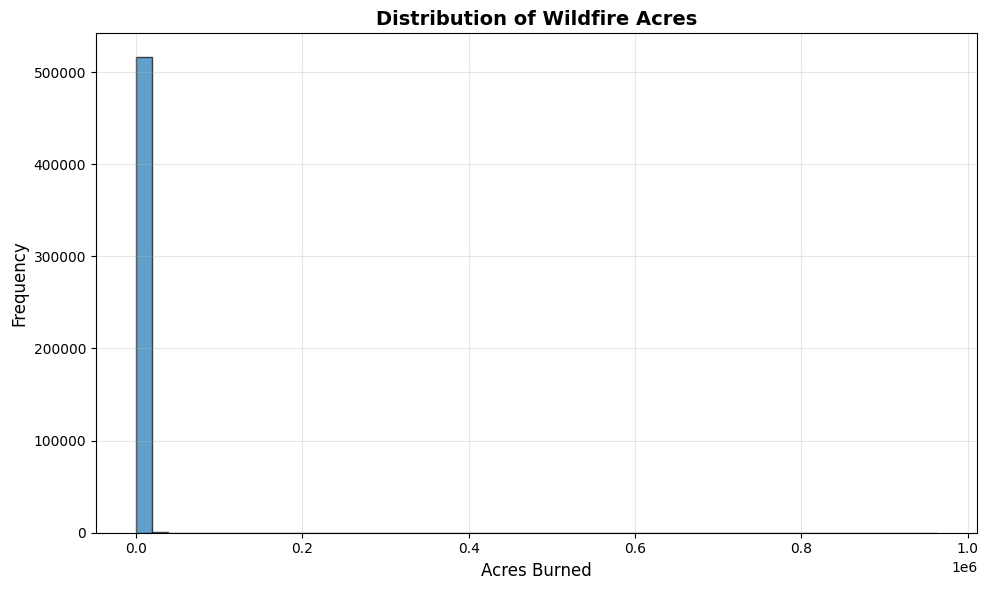

In [21]:
# Visualize distribution of wildfire acreage
plt.figure(figsize=(10, 6))
plt.hist(acres_clean_df["TOTALACRES"], bins=50, edgecolor="black", alpha=0.7)
plt.xlabel("Acres Burned", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Wildfire Acres", fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [22]:
# Check maximum acres value
max_acres = acres_clean_df["TOTALACRES"].max()
print(f"Maximum acres burned: {max_acres:,.2f}")

Maximum acres burned: 963,309.00


In [23]:
max_acres = acres_clean_df["TOTALACRES"].idxmax()
print(acres_clean_df.loc[max_acres])

X                                                          -121.378833
Y                                                               39.876
OBJECTID                                                     314239365
GLOBALID                        {4BCBFB26-835E-4620-A4B4-0182BB41C5A3}
FIREOCCURID                       E9DB628D-DFB7-4C85-BCD6-1254574D946B
CN                                                                 NaN
REVDATE                                         2021/12/20 09:22:24+00
FIRENAME                                                         DIXIE
COMPLEXNAME                                                        NaN
FIREYEAR                                                        2021.0
UNIQFIREID                                           2021-CABTU-009205
SOFIRENUM                                                          NaN
LOCALFIRENUM                                                       NaN
SECURITYID                                                          05
DISCOV

This wasn't a typo--the dixie fire actually existed and was massive.

In [24]:
# Save cleaned dataframe with selected columns
final_clean_df = acres_clean_df[[
    "TOTALACRES",
    "LONGDD83",
    "LATDD83",
    "DISCOVERYDATETIME"
]]

print(f"Final cleaned dataframe shape: {final_clean_df.shape}")
print(f"\nColumns saved: {final_clean_df.columns.tolist()}")

# Save to CSV
final_clean_df.to_csv(OUTPUT_PATH, index=False)
print(f"\nData saved to: {OUTPUT_PATH}")

Final cleaned dataframe shape: (516892, 4)

Columns saved: ['TOTALACRES', 'LONGDD83', 'LATDD83', 'DISCOVERYDATETIME']

Data saved to: ../data/clean_dates_and_locs.csv
